In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
complaints = pd.read_pickle('../data/complaints_df.pkl')
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353432 entries, 0 to 353431
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   complaint        353432 non-null  object 
 1   category         353432 non-null  object 
 2   word_count       353432 non-null  int64  
 3   char_count       353432 non-null  int64  
 4   avg_word_len     353432 non-null  float64
 5   complaint_clean  353432 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 16.2+ MB


In [3]:
X = complaints[['complaint_clean']]
y = complaints['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 369, stratify = y)

In [4]:
vect = CountVectorizer()

X_train_vec = vect.fit_transform(X_train['complaint_clean'])
X_test_vec = vect.transform(X_test['complaint_clean'])

In [6]:
from collections import Counter
from scipy import sparse
from scipy.sparse.linalg import svds
import gensim

In [7]:
complaint_counter = Counter()

for complaint in X_train['complaint_clean']:
    complaint_counter.update(gensim.utils.simple_preprocess(complaint))

word_index = {word: i for i, word in enumerate(complaint_counter.keys())}
index_word = {i: word for i, word in enumerate(complaint_counter.keys())}

window_size = 2

cooccurrence_counter = Counter()

for complaint in X_train['complaint_clean']:
    # First, tokenize the sentence
    sentence = gensim.utils.simple_preprocess(complaint)
    
    # Then, we'll build the window around each word
    for i, word in enumerate(sentence):
        window = sentence[max(0, i-2): i] + sentence[i+1: i+3]

        # Then, we'll up the counter value for that pair
        for other_word in window:
            cooccurrence_counter[(word, other_word)] += 1

In [8]:
row_idx = []
col_idx = []
counts = []

for (word1, word2) in cooccurrence_counter.keys():
    row_idx.append(word_index[word1])
    col_idx.append(word_index[word2])
    counts.append(cooccurrence_counter[(word1, word2)])

cooccurrence_matrix = sparse.csc_matrix((counts, (row_idx, col_idx)), dtype = 'float')

dimension = 50

U, D, V = svds(cooccurrence_matrix, k = dimension)

word_vectors = U * D

In [9]:
def make_vector_matrix(complaint, word_vectors):
    embedding = np.zeros(shape = (word_vectors.shape[1],))
    count = 0
    for word in gensim.utils.simple_preprocess(complaint):
        if word_index.get(word):
            embedding += word_vectors[word_index[word]]
            count += 1
    if count > 0:
        embedding /= count
    
    return embedding

In [10]:
X_train_vec = np.vstack(X_train['complaint_clean'].apply(lambda x: make_vector_matrix(x, word_vectors)))
X_test_vec = np.vstack(X_test['complaint_clean'].apply(lambda x: make_vector_matrix(x, word_vectors)))

In [11]:
logreg = LogisticRegression(max_iter = 10000).fit(X_train_vec, y_train)

y_pred = logreg.predict(X_test_vec)

confusion_matrix(y_test, y_pred)

array([[ 8347,   926,   235,  8309,   474],
       [ 1001,  2823,   138,   898,   451],
       [  145,   181,  1089,  1245,   427],
       [ 2746,   274,   248, 53500,   558],
       [   87,   176,    76,   755,  3249]], dtype=int64)

In [19]:
accuracy_score(y_test, y_pred)

0.7810045496729215

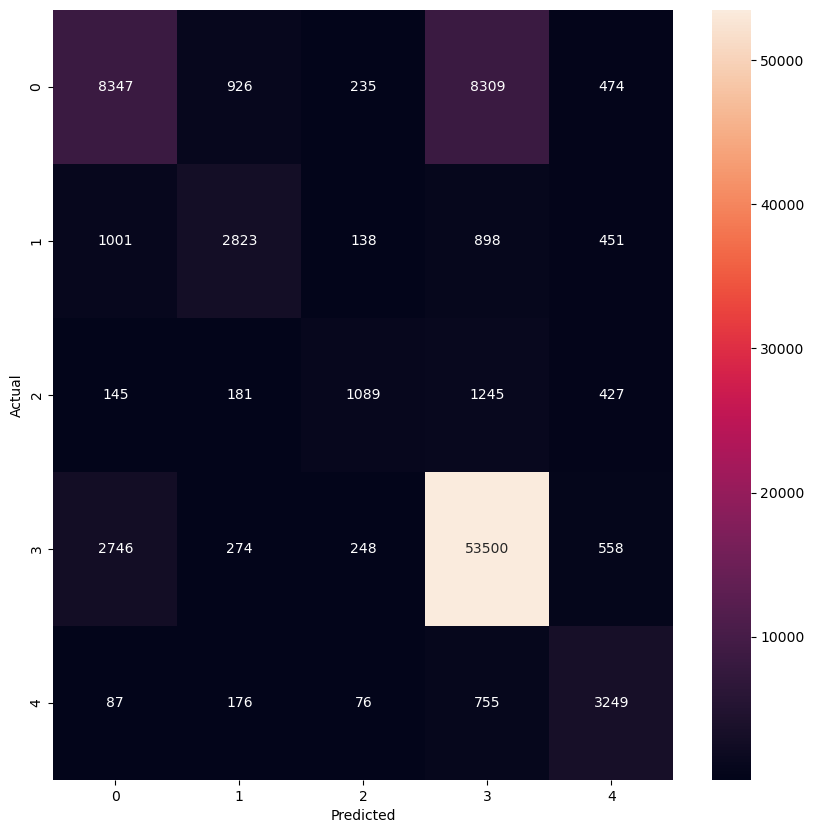

In [18]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d'
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Word2Vec from gensim